# Using the toolkit
***


In order to get the quantum circuit we want, we need to know the Objective function and then convert it into a hamiltonian expression. The toolkit is designed to help users to generate the quantum circuit by automating the process of converting the objective function into a Phase/Cost Hamiltonian.

First we have to import the toolkit from hamiltonian under hamiltonian_engine. We need both mixer and phase hamiltonian packages to aid with circuit generation. There is also a expectation value package that helps to conslidate and produce expectation values from the circuit:

In [1]:
import os 
os.path.sys.path.append('../hamiltonian_engine/')
from hamiltonian import phase_hamiltonian as phs_ham
from hamiltonian import mixer_hamiltonian as mix_ham
from expectation_value import expectation_value as ex_vle

## Phase Hamiltonians
***
Next, the user has to declare an objective function $f(x)$ : $ x_1 + x_2 - 2*x_1*x_2$ and a list of variables that must be found in $f(x)$. 

In [2]:
obj_function = 'x_u + x_v - 2*x_u*x_v'
variables = ['x_v','x_u']

To initialize the phase hamiltonian object, we to provide it with the objective function, $f(x)$ and the list of variables present and the equation will be converted into symbols. The user can call the phase hamiltonian object to produce $f(x)$ using the *get_objFun()*:

In [3]:
phase_h = phs_ham(obj_function,variables)
phase_h.get_objFun()

-2*x_u*x_v + x_u + x_v

The next step would be to convert $f(x)$ into $H_f$, for that we use the *Hamify()* function. The Hamify function follows a set rules in order to get different types of Phase/Cost Hamiltonians. For an arithmethic expression such as $f(x)$, the $x_1, x_2$ variables are then converted into an Pauli expression consisting of Pauli Z matrices in the form: $\frac{1}{2} (I - Z_i)$. Finally we get :

In [4]:
phase_h.Hamify()
phase_h.get_pHamil()

0.5*I - 0.5*Z_u*Z_v

 However the zz pauli expression above my not add up, this is because we are not interested in the global phase factors in the quantum circuits. If the user still wishes to see the proper expansion of $f(x)$ to $H_f$. Then the user can choose to set the option of not removing the global phase factors by setting global_phse to "False".The Identiy Matrix $I$ is treated as 1 in all expansion,as such we get:

In [5]:
phase_h.Hamify()
phase_h.get_pHamil()

0.5*I - 0.5*Z_u*Z_v

In some, cases the certain expressions tend to form powers in the arguments, by default the toolkit reduces them to power 1 since it does not affect the calculations, however, users have an option to leave the powers above 1 alone:

In [6]:
# declare an objective function
obj_func2 = 'x_1 ** 2'
variables2 = ['x_1']

# Instantiate new hamiltonian and Hamify!
phase_h2 = phs_ham(obj_func2, variables2)
phase_h2.Hamify(pwr_args=False)
phase_h2.get_pHamil()

0.25*I + 0.25*Z_1**2 - 0.5*Z_1

## Mixer Hamiltonians
***
The mixer hamiltonian package helps to generate a mixer hamiltonian based on the problem. For now let's just stick to Pauli X rotation gates to allow transition between all feasible subspace i.e. all possible bit string combinations. Instantiate a new mixer hamiltonian class using the phase Hamiltonian:

In [7]:
mx_ham = mix_ham()

##### Warning: If the user decides to generate the circuit from the phase/mixer hamiltonian package, then it is highly adivsed to leave the *Hamify()* function to its default values
This is so that we can generate the quantum circuit based on the necessary pauli expressions

In [8]:
phase_h.Hamify()
phase_h.get_pHamil()

0.5*I - 0.5*Z_u*Z_v

Then Users can import all the necessary packages from qiskit to run the circuit.

In [9]:
# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import execute
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In order to generate the full QAOA circuit the users need to have the mixer and phase hamiltonians. For the Mixer Hamiltonians, users call the function *generalXMixer()* function to allow transistion to all subspaces.

For the phase hamiltonian, users can choose to either map each the variables in the list/equation to an individual qubit or map the $H_f$ (containing only **2 variables**) to each edge of a graph. In this case, we use a per Qubit mapper

The **_perQubitMap()_** function have the following parameters:<br>             
- **gamma**  : 
    rotation angle values for the cost/phase Hamiltonian 
- **p**      :
    Steps to determine the depth of the circuit
- **barrier**:
    Choice to place a quantum barrier after the phase hamiltonian portion of the circuit
- **initial_Hadamard**:
    If Users want they have a choice to assign a hadamard gates to all variables to be in superposition
             
The **_generalXMixer()_** function have the following parameters:<br>             
- **betas**  : 
    rotation angle values for the mixer Hamiltonian 
- **p**      :
    Steps to determine the depth of the circuit
- **measure**:
    Choice to measure all the qubits and store in a classical register
- **graph_map**:
    If a graph needs to used to map the qubits 
- **graph**:
    A Networkx graph that the problem is based on  

In [10]:
gammas = [0.0]
betas = [0.0]
phase_h.perQubitMap(gammas, 1, True, True) 
phase_hMap = phase_h.qubit_map
mx_ham.generalXMixer(betas,1,phase_hMap,True)

Finally the full circuit would look like:<br>
<br>
#### *All of the examples above has p value of 1

**QUESTION**:
1. How would a circuit with p=2 or more be generated?

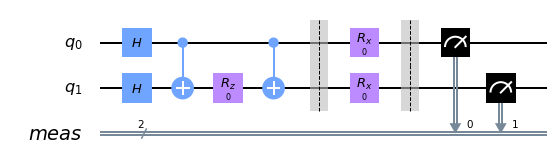

In [11]:
cir = phase_h.get_quantumCircuit() + mx_ham.get_quantumCircuit()
cir.draw(output='mpl')

In [12]:
# run on local simulator
backend      = Aer.get_backend("qasm_simulator")
shots        = 1000

simulate     = execute(cir, backend=backend, shots=shots)
res = simulate.result()

After simulating the circuit, the next step is calculate the expectation value for that, we have an expectation value package that we can use:

In [13]:
# Instantiate object for expectation value
expt = ex_vle(obj_function,variables,is_graph=False)

expt.use_qubitMap(qubit_map=phase_hMap)

#Calculate the results
expt.get_expectationValue(res, shots)

0.00048699999999999997

However, this expecation value does not make sense now, since the rotation angles $\gamma$ and $\beta$ were random. The *hamiltonian* class helps the user generate $U(C,\gamma)$ and $U(B,\beta)$ parts of the circuits, which is useful for **QUBO** or similar problems

### Boolean functions and Graphs:
***
Some objective functions come in the form of boolean expressions, hence the engine is able convert boolean function $f(x)$  to $H_f$. However, the user has to declare that the $f(x)$ is a boolean expression, when the **Hamify()** function is called:

In [14]:
bool_exp = '~x_u & x_v | ~x_v & x_u'
variables = ['x_v','x_u']

phase_h = phs_ham(bool_exp,variables)
phase_h.get_objFun()

(x_u & ~x_v) | (x_v & ~x_u)

When $f(x)$ has been converted to $H_f$,  we realise that the $H_f$ is the same as the function: $f(x)$ : $ x_1 + x_2 - 2*x_1*x_2$ which also known as $x_1\oplus x_2$:

In [15]:
phase_h.Hamify(boolean=True)
phase_h.get_pHamil()

0.5*I - 0.5*Z_u*Z_v

Hamiltonian engine uses networkx to map the graphs onto the circuits. Using networkx one can create a simple graph:

/home/anand/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


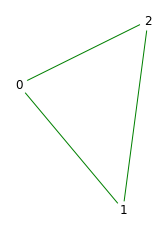

In [16]:
import networkx as nx 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter

#Generate a graph here using networkx
# Number of Nodes
n = 3
degree = 2

# Create the graph
G = nx.random_regular_graph(degree, n)
plt.subplot(121)

nx.draw(G,with_labels=1, pos=nx.spring_layout(G), node_color='w', edge_color='g')

The phase hamiltonian can then be mapped onto each edge, Users have to make sure that the boolean function only contains 2 variables so that the function can be mapped onto each edge of the graph, this is simulate functions that contains $\sum_{(U,V) \epsilon E} f(x)$ <br>
The **_perEdgeMap()_** function have the following parameters:<br>             
- **gamma**  : 
    rotation angle values for the cost/phase Hamiltonian 
- **p**      :
    Steps to determine the depth of the circuit
- **G**      : The networkx graph that the mapping should be based on
- **barrier**:
    Choice to place a quantum barrier after the phase hamiltonian portion of the circuit
- **initial_Hadamard**:
    If Users want they have a choice to assign a hadamard gates to all variables to be in superposition
             

In [17]:
gammas = [1.0]
betas  = [1.0]

phase_h.perEdgeMap(gammas,1, G, True, True)
phase_hMap = phase_h.qubit_map

mx_ham.generalXMixer(betas,1, phase_hMap, True)

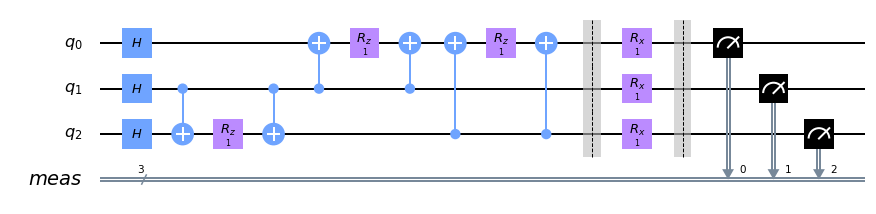

In [18]:
cir_graph = phase_h.get_quantumCircuit() + mx_ham.get_quantumCircuit()
cir_graph.draw(output='mpl')

After generating the quantum circuit, Users can calulate the expectation value of the circuit. In true, QAOA fashion the hyperparameters have to be tuned to get the maximum expectation value of the problem. Users can use SciPy's optimization algorithms to tune the rotation values of the gate.

In [19]:
res_graph = ex_vle(obj_function,variables,is_graph=True)

In [20]:
# run on local simulator
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(cir_graph, backend=backend, shots=shots)
results = simulate.result()

res_graph.get_expectationValue(results,shots,G)

0.1274

### k-Dit Mapping (Experimental)
***

k-dit mapping function is used to generate the phase hamiltonian circuit, this aims to be useful for problems such as Graph-$k$-Colouring, where $f(x)= m - \sum_{(u,v) \epsilon E} \sum_{i = 1}^k x_{u,i} x_{v,i}$, m is the number of Edges. Based on previous examples, we will still tackle the objective function, ignoring the $\sum_{i=1}^k$ terms, hence defining the objective function as $f(x) = x_u x_v$. We can still follow the same few first steps:

In [21]:
import os 
os.path.sys.path.append('../hamiltonian_engine/')
from hamiltonian import phase_hamiltonian as phs_ham
from hamiltonian import mixer_hamiltonian as mix_ham
from qiskit import *


obj_function = 'x_u * x_v + x_v * x_u'
variables = ['x_u','x_v']

phase_h = phs_ham(obj_function,variables)

In [22]:
phase_h.Hamify()
phase_h.get_pHamil()

0.5*I + 0.5*Z_u*Z_v - 0.5*Z_u - 0.5*Z_v

Generate a graph using networkx:

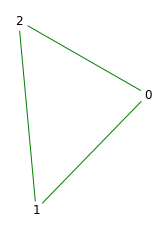

In [23]:
import networkx as nx 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter

#Generate a graph here using networkx
# Number of Nodes
n = 3
degree = 2

# Create the graph
G = nx.random_regular_graph(degree, n)
plt.subplot(121)

nx.draw(G,with_labels=1, pos=nx.spring_layout(G), node_color='w', edge_color='g')

The next step is to call the **_perDitMap()_** function,this is where will consider the $\sum_{i=1}^k$ terms. Based on the objective function earlier, both variables had the subscript $i$, $x_{u,i} x_{v,i}$, however in some cases the objective function may be defined as $f(x)= \sum_{(u,v) \epsilon E}d_{u,v} \sum_{i = 1}^k x_{u,i} x_{v,i + 1} + x_{v,i}x_{u,i+1}$, which is the Travelling Salespersons Problem. In order to tackle that, the **_perDitMap()_** function contains a _sub_expr_ argument, where users can define the next variables interaction. 
Our current example both have $i$ thus the _sub_expr_={'$i$':'$i$'} which is also the default value, however if we want to map according the TSP, then _sub_expr_={'$i$': '$i$ + 1'}.<br>
**To Note**:<br>
The calculation for _sub_expr_ used a % expression to ensure the mapping will not get out of index error

The **_perDitMap()_** function have the following parameters:<br>             
- **gamma**  : 
    rotation angle values for the cost/phase Hamiltonian 
- **p**      :
    Steps to determine the depth of the circuit
- **k_dits** :
    Number of qubits assigned to each vertex of the Graph
- **sub_expr**:
    Default={'i':'i'}, else users can change the value expression of the dict,but always keeping the key as 'i'
- **barrier**:
    Choice to place a quantum barrier after the phase hamiltonian portion of the circuit
- **initial_Hadamard**:
    If Users want they have a choice to assign a hadamard gates to all variables to be in superposition

Users can also check how the $k$-Dits are mapped by calling the _.qudit_map_ after calling the **_perDitMap()_** function

In [24]:
gamma = [0.9]
phase_h.perDitMap(gamma, 1, 2, G, sub_expr={'i':'i'})
phase_h.qubit_map

{0: (0, 1), 1: (2, 3), 2: (4, 5)}

The expression given was {'$i$': '$i$'}:

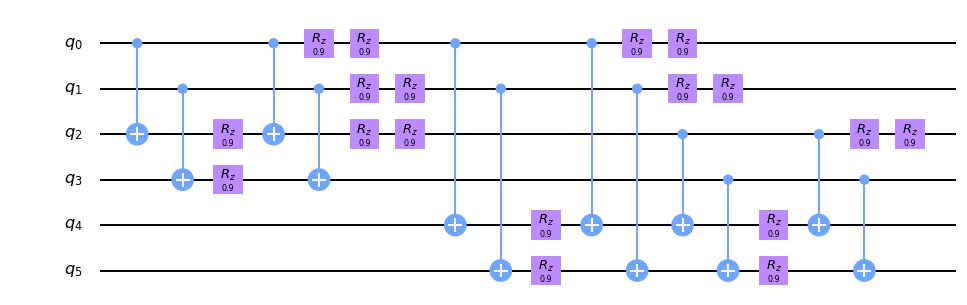

In [25]:
quantum_circuit = phase_h.get_quantumCircuit()
quantum_circuit.draw(output='mpl')

However, if the expression given was {'$i$': '$i$ + 1'}, then we can see the shift in the circuit:

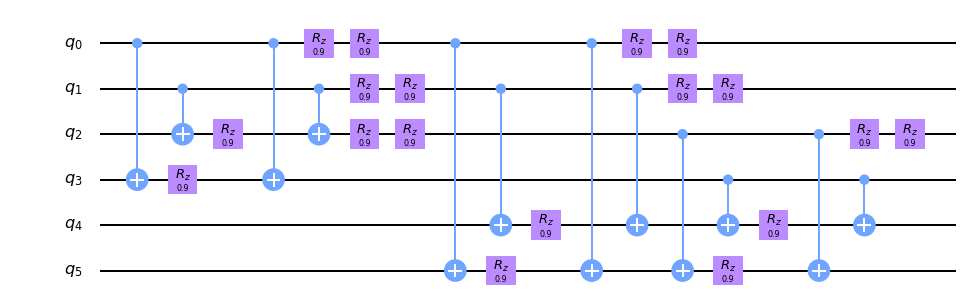

In [26]:
phase_h.perDitMap(gamma, 1, 2, G, sub_expr={'i':'i+1'})
quantum_circuit = phase_h.get_quantumCircuit()
quantum_circuit.draw(output='mpl')

In [34]:
phase_h.get_pHamil()

1.5*I - 0.5*Z_0*Z_1 - 0.5*Z_0*Z_2 - 0.5*Z_1*Z_2

The hamiltonian class tries to minimize the calculations required to generate the QAOA circuits for the users, but still allows tries to provide the users with the flexibility to add on or modify the circuits.

The next part is the predefined examples of **MAX-CUT**>>>

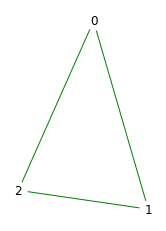

In [27]:
import numpy as np
import os 
os.path.sys.path.append('../hamiltonian_engine/')
from hamiltonian import phase_hamiltonian as phs_ham
from hamiltonian import mixer_hamiltonian as mix_ham
import networkx as nx 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
#Generate a graph here using networkx
# Number of Nodes

# Create the graph
n     = 3
V     = np.arange(0,n,1)
E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)
plt.subplot(121)

nx.draw(G,with_labels=1, pos=nx.spring_layout(G), node_color='w', edge_color='g')

In [28]:
obj_function = '~x_u * x_v + ~x_v * x_u'
variables = ['x_u','x_v']

phase_h = phs_ham(obj_function,variables)
phase_h.Hamify()
gammas = [1.0]
betas  = [1.0]
mx_ham = mix_ham()
phase_h.perEdgeMap(gammas,1, G, False, False)
phase_hMap = phase_h.qubit_map

mx_ham.controlledXMixer(betas,1, G, False, True)

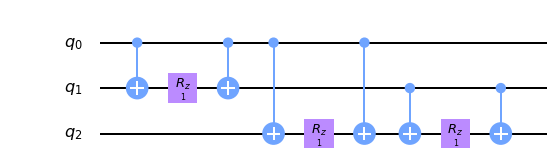

In [29]:
cir_p = phase_h.get_quantumCircuit()
cir_p.draw(output='mpl')

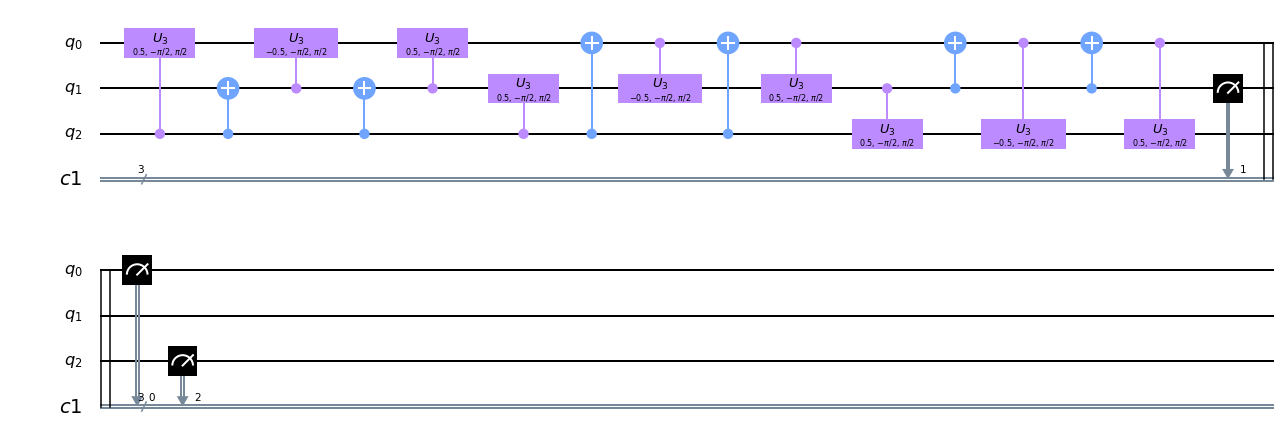

In [30]:
mx_ham.controlledXMixer(betas,1, G, False, True)
cir_m = mx_ham.get_quantumCircuit()
cir_m.draw(output='mpl')

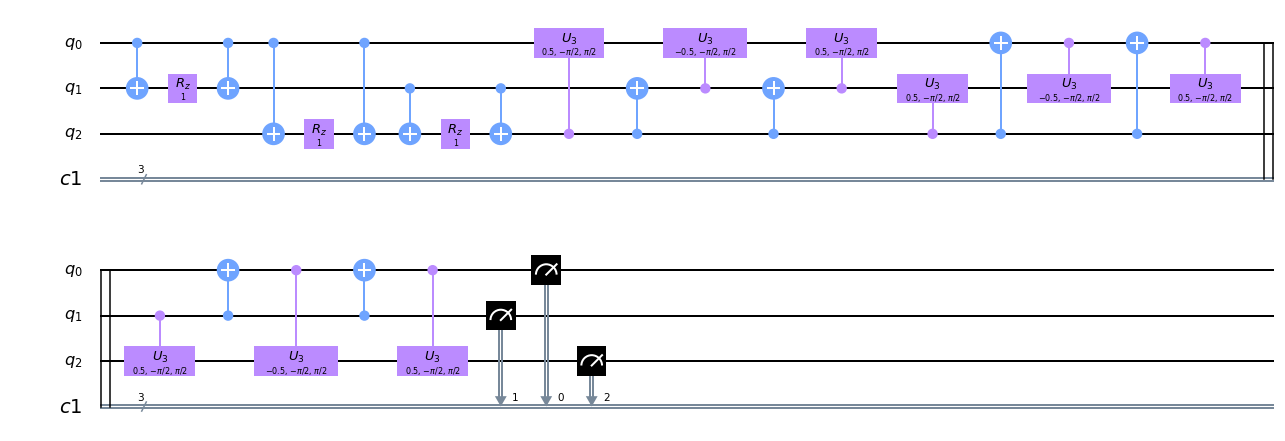

In [31]:
cir_full = phase_h / mx_ham
cir_full.draw(output='mpl')

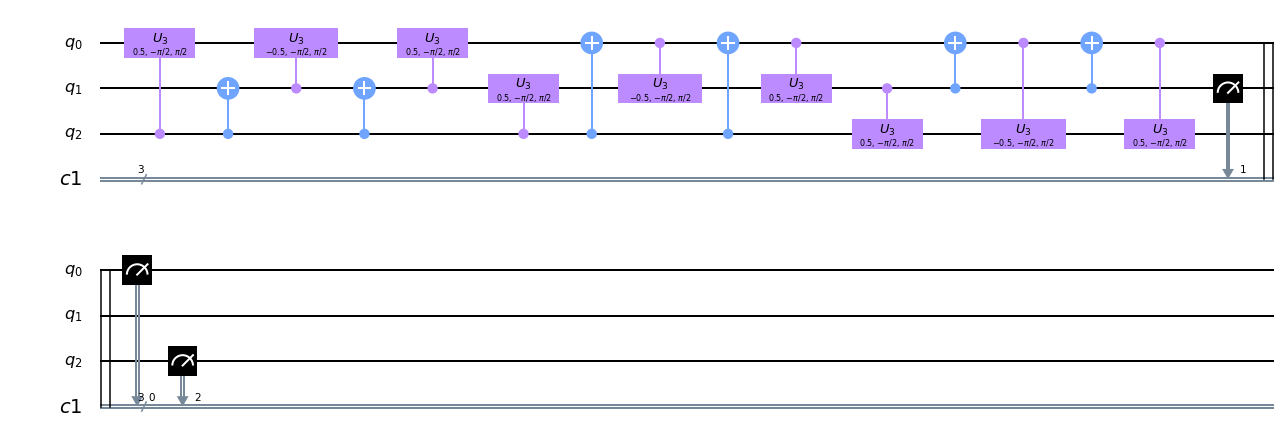

In [32]:
cir_m = mx_ham.get_quantumCircuitAslist()
cir_m[0].draw(output='mpl')

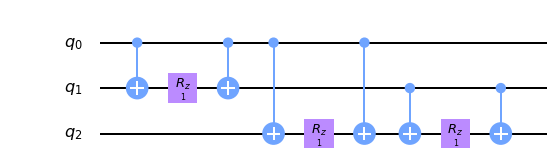

In [33]:
cir_p = phase_h.get_quantumCircuitAslist()
cir_p[0].draw(output='mpl')